Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['O', 'B-treatment', 'I-test', 'I-problem', 'B-problem', 'I-treatment', 'B-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['O', 'B-treatment', 'I-test', 'I-problem', 'B-problem', 'I-treatment', 'B-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['O', 'B-treatment', 'I-test', 'I-problem', 'B-problem', 'I-treatment', 'B-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

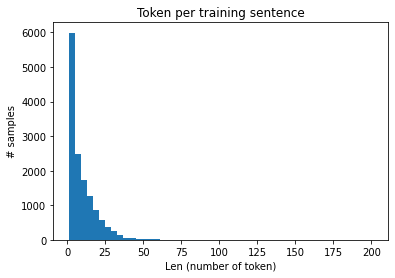

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

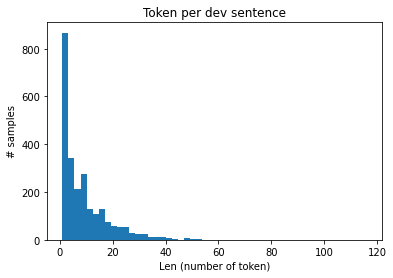

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

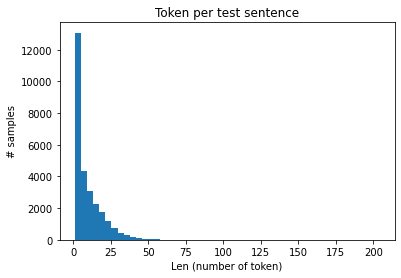

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

18832
0.56
1
B-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9892)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[28088, 3380, 5396, 436, 26770, 19376, 7532, 22579, 25326, 27262, 22656, 18578, 9189]
[0, 0, 0, 0, 0, 1, 5, 5, 0, 0, 0, 0, 0]
[24574, 7321, 18940, 26959, 18463, 7021, 12920, 20495, 4093, 1096, 14944, 9189]
[4, 3, 3, 3, 3, 3, 0, 6, 2, 2, 2, 0]
[1753, 25501, 3380]
[0, 0, 0]
18832
1
I-test
861
28388
7


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 120 kB 49.4 MB/s 
     |████████████████████████████████| 6.6 MB 37.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f4bb0e5b41ea5e458a4bff53c548c42ec8599b42ee0f33ed16d8424ece7ba3e9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[28088, 3380, 5396, 436, 26770, 19376, 7532, 22579, 25326, 2

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1018028259277344
Training loss epoch: 1.0040830334027608
Training accuracy epoch: 0.7193278478991282
Validating model...
Validation Loss: 0.6956991228190336
Validation Accuracy: 0.7753034024476178
Training epoch: 2
Training loss per 100 training steps: 0.8187696933746338
Training loss epoch: 0.4622805292407672
Training accuracy epoch: 0.8529860999295327
Validating model...
Validation Loss: 0.5276077552275225
Validation Accuracy: 0.8356101664493676
Training epoch: 3
Training loss per 100 training steps: 0.12660200893878937
Training loss epoch: 0.25438573956489563
Training accuracy epoch: 0.9262148911463715
Validating model...
Validation Loss: 0.4604495245140868
Validation Accuracy: 0.8507278039826149
Training epoch: 4
Training loss per 100 training steps: 0.08335902541875839
Training loss epoch: 0.12150340384493272
Training accuracy epoch: 0.9763869331713579
Validating model...
Validation Loss: 0.4262563828137014
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40158094512298703
Validation Accuracy: 0.8812046880413051


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.2825024 minutes
F1-score (test): 56.0%
              precision    recall  f1-score   support

     problem       0.47      0.66      0.54     12546
        test       0.53      0.62      0.57      9012
   treatment       0.55      0.60      0.58      9297

   micro avg       0.51      0.63      0.56     30855
   macro avg       0.51      0.62      0.56     30855
weighted avg       0.51      0.63      0.56     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.825505256652832
Training loss epoch: 0.9325044274330139
Training accuracy epoch: 0.7500426804043734
Validating model...
Validation Loss: 0.7001919831548419
Validation Accuracy: 0.7813803519867064
Training epoch: 2
Training loss per 100 training steps: 0.5141468048095703
Training loss epoch: 0.46483695606390635
Training accuracy epoch: 0.8607676230269845
Validating model...
Validation Loss: 0.48507698093141827
Validation Accuracy: 0.8429416364441472
Training epoch: 3
Training loss per 100 training steps: 0.16466912627220154
Training loss epoch: 0.20892702241738637
Training accuracy epoch: 0.9390788229856936
Validating model...
Validation Loss: 0.40868179674272415
Validation Accuracy: 0.8668394884468719
Training epoch: 4
Training loss per 100 training steps: 0.10659626126289368
Training loss epoch: 0.09058937753240268
Training accuracy epoch: 0.978594483199012
Validating model...
Validation Loss: 0.4138591947493615
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4154898535839661
Validation Accuracy: 0.8668711782454243
Validation duration: 3.1630037499999997 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 54.9%
              precision    recall  f1-score   support

     problem       0.45      0.61      0.52     12546
        test       0.55      0.57      0.56      9012
   treatment       0.51      0.67      0.58      9297

   micro avg       0.49      0.62      0.55     30855
   macro avg       0.50      0.62      0.55     30855
weighted avg       0.50      0.62      0.55     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9349071979522705
Training loss epoch: 0.9542223453521729
Training accuracy epoch: 0.7296817742937346
Validating model...
Validation Loss: 0.7350284461077158
Validation Accuracy: 0.7632519151547278
Training epoch: 2
Training loss per 100 training steps: 0.5437872409820557
Training loss epoch: 0.541827400525411
Training accuracy epoch: 0.826154206715287
Validating model...
Validation Loss: 0.5205579535527662
Validation Accuracy: 0.830588085996671
Training epoch: 3
Training loss per 100 training steps: 0.04028543084859848
Training loss epoch: 0.2847658241788546
Training accuracy epoch: 0.9133526164833119
Validating model...
Validation Loss: 0.42355233759849104
Validation Accuracy: 0.8645331746091063
Training epoch: 4
Training loss per 100 training steps: 0.13020923733711243
Training loss epoch: 0.12479264910022418
Training accuracy epoch: 0.9709752416851406
Validating model...
Validation Loss: 0.395814546710485
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4084435889531893
Validation Accuracy: 0.8715207491958438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1631302000000003 minutes
F1-score (test): 52.6%
              precision    recall  f1-score   support

     problem       0.40      0.65      0.49     12546
        test       0.53      0.55      0.54      9012
   treatment       0.56      0.58      0.57      9297

   micro avg       0.47      0.60      0.53     30855
   macro avg       0.50      0.59      0.53     30855
weighted avg       0.49      0.60      0.53     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9185296297073364
Training loss epoch: 0.9933273911476135
Training accuracy epoch: 0.7234123685349285
Validating model...
Validation Loss: 0.777340313830933
Validation Accuracy: 0.7934020955706805
Training epoch: 2
Training loss per 100 training steps: 0.9717649817466736
Training loss epoch: 0.5565461059411366
Training accuracy epoch: 0.8339456815143935
Validating model...
Validation Loss: 0.5331413861993072
Validation Accuracy: 0.8344352203084949
Training epoch: 3
Training loss per 100 training steps: 0.11903936415910721
Training loss epoch: 0.31572805196046827
Training accuracy epoch: 0.9100174114005462
Validating model...
Validation Loss: 0.4283838372725945
Validation Accuracy: 0.8623345930868903
Training epoch: 4
Training loss per 100 training steps: 0.19882211089134216
Training loss epoch: 0.1541074611246586
Training accuracy epoch: 0.9652751240657083
Validating model...
Validation Loss: 0.4388354012331405
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40028280017173123
Validation Accuracy: 0.8855059991993303
Validation duration: 3.154179133333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.4%
              precision    recall  f1-score   support

     problem       0.52      0.58      0.55     12546
        test       0.54      0.57      0.55      9012
   treatment       0.62      0.64      0.63      9297

   micro avg       0.55      0.60      0.57     30855
   macro avg       0.56      0.60      0.58     30855
weighted avg       0.55      0.60      0.57     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.061936378479004
Training loss epoch: 1.0624237696329752
Training accuracy epoch: 0.7007079500918495
Validating model...
Validation Loss: 0.693045952877441
Validation Accuracy: 0.7864056342815345
Training epoch: 2
Training loss per 100 training steps: 0.739953875541687
Training loss epoch: 0.48899115025997164
Training accuracy epoch: 0.8461694059360118
Validating model...
Validation Loss: 0.49923412095416675
Validation Accuracy: 0.8413578884331795
Training epoch: 3
Training loss per 100 training steps: 0.5661228895187378
Training loss epoch: 0.2307467003663381
Training accuracy epoch: 0.9392845214939985
Validating model...
Validation Loss: 0.44129649849681113
Validation Accuracy: 0.8648721972919142
Training epoch: 4
Training loss per 100 training steps: 0.11899478733539581
Training loss epoch: 0.10387549599011739
Training accuracy epoch: 0.9746121810472738
Validating model...
Validation Loss: 0.4146947551083255
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4181472763626112
Validation Accuracy: 0.8745672978943352
Validation duration: 3.148611749999998 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 54.7%
              precision    recall  f1-score   support

     problem       0.46      0.64      0.53     12546
        test       0.48      0.62      0.54      9012
   treatment       0.55      0.60      0.58      9297

   micro avg       0.49      0.62      0.55     30855
   macro avg       0.50      0.62      0.55     30855
weighted avg       0.49      0.62      0.55     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2960500717163086
Training loss epoch: 1.0617392897605895
Training accuracy epoch: 0.7151116334748528
Validating model...
Validation Loss: 0.6891004183849732
Validation Accuracy: 0.7779486665968794
Training epoch: 2
Training loss per 100 training steps: 0.6095792651176453
Training loss epoch: 0.47437547544638314
Training accuracy epoch: 0.8566936039145188
Validating model...
Validation Loss: 0.5037434902284053
Validation Accuracy: 0.831345927567349
Training epoch: 3
Training loss per 100 training steps: 0.23749926686286926
Training loss epoch: 0.2706728180249532
Training accuracy epoch: 0.9161740221836298
Validating model...
Validation Loss: 0.45426826585422864
Validation Accuracy: 0.857568582763593
Training epoch: 4
Training loss per 100 training steps: 0.1904260814189911
Training loss epoch: 0.15777951702475548
Training accuracy epoch: 0.9588087872596454
Validating model...
Validation Loss: 0.40239571170373395
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40650031256868885
Validation Accuracy: 0.8789007751102209
Validation duration: 3.151549083333331 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.8%
              precision    recall  f1-score   support

     problem       0.39      0.59      0.47     12546
        test       0.56      0.65      0.60      9012
   treatment       0.59      0.58      0.58      9297

   micro avg       0.48      0.61      0.54     30855
   macro avg       0.51      0.61      0.55     30855
weighted avg       0.50      0.61      0.54     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9135711193084717
Training loss epoch: 0.9981201330820719
Training accuracy epoch: 0.7294318923624625
Validating model...
Validation Loss: 0.6801996068520979
Validation Accuracy: 0.7885369399895539
Training epoch: 2
Training loss per 100 training steps: 0.5095415711402893
Training loss epoch: 0.41955949465433756
Training accuracy epoch: 0.8733566319541813
Validating model...
Validation Loss: 0.4728842756964944
Validation Accuracy: 0.8474764201574292
Training epoch: 3
Training loss per 100 training steps: 0.2711943984031677
Training loss epoch: 0.20641229326526325
Training accuracy epoch: 0.939631615036148
Validating model...
Validation Loss: 0.4746474286952576
Validation Accuracy: 0.8563344471993743
Training epoch: 4
Training loss per 100 training steps: 0.02265433594584465
Training loss epoch: 0.11001099646091461
Training accuracy epoch: 0.9721613458238777
Validating model...
Validation Loss: 0.44281478593875834
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42787660582473985
Validation Accuracy: 0.881053617783545
Validation duration: 3.149755433333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 56.9%
              precision    recall  f1-score   support

     problem       0.51      0.62      0.56     12546
        test       0.49      0.67      0.57      9012
   treatment       0.53      0.66      0.59      9297

   micro avg       0.51      0.64      0.57     30855
   macro avg       0.51      0.65      0.57     30855
weighted avg       0.51      0.64      0.57     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.449167013168335
Training loss epoch: 1.024026127656301
Training accuracy epoch: 0.7180465697719923
Validating model...
Validation Loss: 0.73533078834608
Validation Accuracy: 0.7911762140414802
Training epoch: 2
Training loss per 100 training steps: 0.3367326259613037
Training loss epoch: 0.4846001903216044
Training accuracy epoch: 0.8481465105065639
Validating model...
Validation Loss: 0.5319107875421449
Validation Accuracy: 0.827545545432411
Training epoch: 3
Training loss per 100 training steps: 0.2393411248922348
Training loss epoch: 0.2622940252224604
Training accuracy epoch: 0.9301775580898997
Validating model...
Validation Loss: 0.43466661928536054
Validation Accuracy: 0.8627344060195813
Training epoch: 4
Training loss per 100 training steps: 0.08850932866334915
Training loss epoch: 0.10166568433245023
Training accuracy epoch: 0.9775446729901459
Validating model...
Validation Loss: 0.4106778266367974
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40827275065843155
Validation Accuracy: 0.8738185347907097
Validation duration: 3.1519408833333347 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.9%
              precision    recall  f1-score   support

     problem       0.51      0.56      0.54     12546
        test       0.43      0.64      0.51      9012
   treatment       0.57      0.57      0.57      9297

   micro avg       0.50      0.59      0.54     30855
   macro avg       0.50      0.59      0.54     30855
weighted avg       0.50      0.59      0.54     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1838464736938477
Training loss epoch: 1.0179929931958516
Training accuracy epoch: 0.702294496288692
Validating model...
Validation Loss: 0.7658109022425367
Validation Accuracy: 0.7783466899521779
Training epoch: 2
Training loss per 100 training steps: 0.7085269093513489
Training loss epoch: 0.49020640552043915
Training accuracy epoch: 0.848790420075833
Validating model...
Validation Loss: 0.5064823166890577
Validation Accuracy: 0.8396804042089079
Training epoch: 3
Training loss per 100 training steps: 0.3499685227870941
Training loss epoch: 0.2545898596445719
Training accuracy epoch: 0.9207949601692835
Validating model...
Validation Loss: 0.41717035816861436
Validation Accuracy: 0.8633822977475222
Training epoch: 4
Training loss per 100 training steps: 0.1447870284318924
Training loss epoch: 0.12072575986385345
Training accuracy epoch: 0.9732341535385552
Validating model...
Validation Loss: 0.4144702919504859
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4181427099284957
Validation Accuracy: 0.8907187692154358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.146305616666662 minutes
F1-score (test): 61.2%
              precision    recall  f1-score   support

     problem       0.53      0.69      0.60     12546
        test       0.60      0.64      0.62      9012
   treatment       0.59      0.66      0.63      9297

   micro avg       0.56      0.67      0.61     30855
   macro avg       0.57      0.66      0.61     30855
weighted avg       0.57      0.67      0.61     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7266128063201904
Training loss epoch: 0.9329924881458282
Training accuracy epoch: 0.7426996013226632
Validating model...
Validation Loss: 0.7322420168232608
Validation Accuracy: 0.7771027746934561
Training epoch: 2
Training loss per 100 training steps: 0.5137836933135986
Training loss epoch: 0.4703921357790629
Training accuracy epoch: 0.8538528928145701
Validating model...
Validation Loss: 0.5000290263008762
Validation Accuracy: 0.8390915227869784
Training epoch: 3
Training loss per 100 training steps: 0.31816762685775757
Training loss epoch: 0.2570069928963979
Training accuracy epoch: 0.926154803311966
Validating model...
Validation Loss: 0.421787522055886
Validation Accuracy: 0.8634089048096838
Training epoch: 4
Training loss per 100 training steps: 0.1815721094608307
Training loss epoch: 0.12436072106162707
Training accuracy epoch: 0.9634047851218113
Validating model...
Validation Loss: 0.4338205557364922
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4343910349567455
Validation Accuracy: 0.859650114256832
Validation duration: 3.1402558166666648 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 47.5%
              precision    recall  f1-score   support

     problem       0.42      0.48      0.45     12546
        test       0.44      0.54      0.49      9012
   treatment       0.47      0.52      0.50      9297

   micro avg       0.44      0.51      0.47     30855
   macro avg       0.45      0.51      0.48     30855
weighted avg       0.44      0.51      0.47     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1512880325317383
Training loss epoch: 0.883096495741292
Training accuracy epoch: 0.738323448914271
Validating model...
Validation Loss: 0.6832717691923117
Validation Accuracy: 0.7817523421623226
Training epoch: 2
Training loss per 100 training steps: 0.5116828680038452
Training loss epoch: 0.43526757234021235
Training accuracy epoch: 0.8638361729287627
Validating model...
Validation Loss: 0.48138429979225256
Validation Accuracy: 0.8420073169873437
Training epoch: 3
Training loss per 100 training steps: 0.17744478583335876
Training loss epoch: 0.15947207156568766
Training accuracy epoch: 0.9582852487491881
Validating model...
Validation Loss: 0.4175312029463904
Validation Accuracy: 0.874450823907894
Training epoch: 4
Training loss per 100 training steps: 0.17081262171268463
Training loss epoch: 0.07373713221597045
Training accuracy epoch: 0.9798141209733423
Validating model...
Validation Loss: 0.4280984090133147
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4286625819384224
Validation Accuracy: 0.8675634157642368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1461941500000044 minutes
F1-score (test): 52.7%
              precision    recall  f1-score   support

     problem       0.45      0.64      0.53     12546
        test       0.48      0.55      0.51      9012
   treatment       0.58      0.51      0.54      9297

   micro avg       0.49      0.58      0.53     30855
   macro avg       0.50      0.57      0.53     30855
weighted avg       0.50      0.58      0.53     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2824134826660156
Training loss epoch: 0.868131581105684
Training accuracy epoch: 0.7442460069584119
Validating model...
Validation Loss: 0.6055473514965602
Validation Accuracy: 0.8124274086041735
Training epoch: 2
Training loss per 100 training steps: 0.5104289054870605
Training loss epoch: 0.3538773177485717
Training accuracy epoch: 0.8911667196360726
Validating model...
Validation Loss: 0.44893145328992373
Validation Accuracy: 0.8473220411797335
Training epoch: 3
Training loss per 100 training steps: 0.1178506538271904
Training loss epoch: 0.13272327243497498
Training accuracy epoch: 0.9592446740883179
Validating model...
Validation Loss: 0.4010129611600529
Validation Accuracy: 0.8800015850233022
Training epoch: 4
Training loss per 100 training steps: 0.10801268368959427
Training loss epoch: 0.05382757114344522
Training accuracy epoch: 0.9899809971695476
Validating model...
Validation Loss: 0.43589193519059716
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40452526319185617
Validation Accuracy: 0.8772323406697082
Validation duration: 3.1442829833333388 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 56.0%
              precision    recall  f1-score   support

     problem       0.47      0.69      0.56     12546
        test       0.48      0.63      0.54      9012
   treatment       0.60      0.56      0.58      9297

   micro avg       0.50      0.63      0.56     30855
   macro avg       0.52      0.63      0.56     30855
weighted avg       0.51      0.63      0.56     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.016045093536377
Training loss epoch: 0.8182067416216198
Training accuracy epoch: 0.7604973975157808
Validating model...
Validation Loss: 0.5759660466150804
Validation Accuracy: 0.8175038881891582
Training epoch: 2
Training loss per 100 training steps: 0.5363231897354126
Training loss epoch: 0.3074750153739986
Training accuracy epoch: 0.9045828601807018
Validating model...
Validation Loss: 0.42170313000679016
Validation Accuracy: 0.8622068367382731
Training epoch: 3
Training loss per 100 training steps: 0.15173788368701935
Training loss epoch: 0.14229576250440196
Training accuracy epoch: 0.9600108759105457
Validating model...
Validation Loss: 0.4282437247502339
Validation Accuracy: 0.8732202650116189
Training epoch: 4
Training loss per 100 training steps: 0.0882326140999794
Training loss epoch: 0.06491653229060926
Training accuracy epoch: 0.986453103486242
Validating model...
Validation Loss: 0.40233215031685765
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.39823382813483477
Validation Accuracy: 0.8857432546512146
Validation duration: 3.1451898000000105 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 58.6%
              precision    recall  f1-score   support

     problem       0.53      0.62      0.57     12546
        test       0.57      0.53      0.55      9012
   treatment       0.63      0.65      0.64      9297

   micro avg       0.57      0.60      0.59     30855
   macro avg       0.58      0.60      0.59     30855
weighted avg       0.57      0.60      0.59     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6358137130737305
Training loss epoch: 0.8650588565751126
Training accuracy epoch: 0.7695358908275111
Validating model...
Validation Loss: 0.6344198185902137
Validation Accuracy: 0.80188753729616
Training epoch: 2
Training loss per 100 training steps: 0.49898651242256165
Training loss epoch: 0.37902613493957016
Training accuracy epoch: 0.8792253422467761
Validating model...
Validation Loss: 0.44293346691441227
Validation Accuracy: 0.8635565053254836
Training epoch: 3
Training loss per 100 training steps: 0.1592540144920349
Training loss epoch: 0.12107188068330288
Training accuracy epoch: 0.9737752828160456
Validating model...
Validation Loss: 0.42771400124221653
Validation Accuracy: 0.8685998269338839
Training epoch: 4
Training loss per 100 training steps: 0.19763843715190887
Training loss epoch: 0.06382779056500447
Training accuracy epoch: 0.9833881171166251
Validating model...
Validation Loss: 0.42898548094483163
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4165736663638166
Validation Accuracy: 0.8957306878823947
Validation duration: 3.143793999999995 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 64.7%
              precision    recall  f1-score   support

     problem       0.60      0.66      0.63     12546
        test       0.64      0.70      0.67      9012
   treatment       0.70      0.61      0.65      9297

   micro avg       0.64      0.66      0.65     30855
   macro avg       0.65      0.66      0.65     30855
weighted avg       0.64      0.66      0.65     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9338421821594238
Training loss epoch: 0.896823010946575
Training accuracy epoch: 0.7535447446033056
Validating model...
Validation Loss: 0.6796122189466055
Validation Accuracy: 0.7857335530258925
Training epoch: 2
Training loss per 100 training steps: 0.5752707123756409
Training loss epoch: 0.4081809606991316
Training accuracy epoch: 0.8691305656823488
Validating model...
Validation Loss: 0.46947336119490785
Validation Accuracy: 0.8483347102386349
Training epoch: 3
Training loss per 100 training steps: 0.10676708072423935
Training loss epoch: 0.16335529441896238
Training accuracy epoch: 0.9607748363270442
Validating model...
Validation Loss: 0.4039690953183484
Validation Accuracy: 0.8788628805310251
Training epoch: 4
Training loss per 100 training steps: 0.05334797129034996
Training loss epoch: 0.06240625463818249
Training accuracy epoch: 0.983843958136589
Validating model...
Validation Loss: 0.42983538938033117
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4039769531055181
Validation Accuracy: 0.8769770973585298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1405535999999907 minutes
F1-score (test): 55.1%
              precision    recall  f1-score   support

     problem       0.44      0.64      0.52     12546
        test       0.51      0.66      0.57      9012
   treatment       0.60      0.56      0.58      9297

   micro avg       0.49      0.62      0.55     30855
   macro avg       0.51      0.62      0.56     30855
weighted avg       0.51      0.62      0.55     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1634373664855957
Training loss epoch: 0.9126747909345125
Training accuracy epoch: 0.7582976464312686
Validating model...
Validation Loss: 0.6377941962186392
Validation Accuracy: 0.7944671085946721
Training epoch: 2
Training loss per 100 training steps: 0.6477720737457275
Training loss epoch: 0.3881134469258158
Training accuracy epoch: 0.8768996108954631
Validating model...
Validation Loss: 0.46208410564955177
Validation Accuracy: 0.8549959147475658
Training epoch: 3
Training loss per 100 training steps: 0.1249367743730545
Training loss epoch: 0.1498056928578176
Training accuracy epoch: 0.9644328218177968
Validating model...
Validation Loss: 0.40783120614367646
Validation Accuracy: 0.8745907301712916
Training epoch: 4
Training loss per 100 training steps: 0.0558447502553463
Training loss epoch: 0.06726098501760709
Training accuracy epoch: 0.9857838570092339
Validating model...
Validation Loss: 0.42391821084084447
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.410896807357117
Validation Accuracy: 0.8731630661052345
Validation duration: 3.146771800000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 54.8%
              precision    recall  f1-score   support

     problem       0.43      0.67      0.52     12546
        test       0.56      0.57      0.56      9012
   treatment       0.52      0.63      0.57      9297

   micro avg       0.49      0.63      0.55     30855
   macro avg       0.50      0.62      0.55     30855
weighted avg       0.50      0.63      0.55     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.798242449760437
Training loss epoch: 0.8733754361930647
Training accuracy epoch: 0.7580527035079886
Validating model...
Validation Loss: 0.6396226577170483
Validation Accuracy: 0.7889172533848962
Training epoch: 2
Training loss per 100 training steps: 0.33890560269355774
Training loss epoch: 0.3461256089963411
Training accuracy epoch: 0.8906361272385076
Validating model...
Validation Loss: 0.4992616970043678
Validation Accuracy: 0.8362372740697848
Training epoch: 3
Training loss per 100 training steps: 0.165167897939682
Training loss epoch: 0.15454451788805032
Training accuracy epoch: 0.9564292678732067
Validating model...
Validation Loss: 0.44624542473972617
Validation Accuracy: 0.8716636144523707
Training epoch: 4
Training loss per 100 training steps: 0.05299253761768341
Training loss epoch: 0.09598631720597807
Training accuracy epoch: 0.9725917172921098
Validating model...
Validation Loss: 0.47361013486787873
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4587270892225206
Validation Accuracy: 0.8678715212873065
Validation duration: 3.1447813833333234 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.1%
              precision    recall  f1-score   support

     problem       0.45      0.57      0.50     12546
        test       0.59      0.55      0.57      9012
   treatment       0.61      0.49      0.54      9297

   micro avg       0.52      0.54      0.53     30855
   macro avg       0.55      0.54      0.54     30855
weighted avg       0.54      0.54      0.53     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.085472583770752
Training loss epoch: 0.8420566994892923
Training accuracy epoch: 0.7596428537056463
Validating model...
Validation Loss: 0.6384020834774166
Validation Accuracy: 0.7931608073269457
Training epoch: 2
Training loss per 100 training steps: 0.5035534501075745
Training loss epoch: 0.3775299238531213
Training accuracy epoch: 0.875281551147089
Validating model...
Validation Loss: 0.45279475407941
Validation Accuracy: 0.8471282096112396
Training epoch: 3
Training loss per 100 training steps: 0.3614303767681122
Training loss epoch: 0.18633320751158813
Training accuracy epoch: 0.9458442396605274
Validating model...
Validation Loss: 0.41170354206840715
Validation Accuracy: 0.8667217124549824
Training epoch: 4
Training loss per 100 training steps: 0.14681342244148254
Training loss epoch: 0.08711107879092819
Training accuracy epoch: 0.980367489233961
Validating model...
Validation Loss: 0.4166190415233761
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4155453438353207
Validation Accuracy: 0.8630642644360166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1426068666666653 minutes
F1-score (test): 52.2%
              precision    recall  f1-score   support

     problem       0.44      0.61      0.51     12546
        test       0.48      0.59      0.53      9012
   treatment       0.60      0.48      0.54      9297

   micro avg       0.49      0.56      0.52     30855
   macro avg       0.51      0.56      0.52     30855
weighted avg       0.50      0.56      0.52     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0988619327545166
Training loss epoch: 0.9475519264999189
Training accuracy epoch: 0.7353128640565482
Validating model...
Validation Loss: 0.6789766155280076
Validation Accuracy: 0.7926426134259734
Training epoch: 2
Training loss per 100 training steps: 0.42665085196495056
Training loss epoch: 0.39270995871016856
Training accuracy epoch: 0.8808521706506567
Validating model...
Validation Loss: 0.4749106451288446
Validation Accuracy: 0.8466797082780677
Training epoch: 3
Training loss per 100 training steps: 0.2880309522151947
Training loss epoch: 0.1509085213275332
Training accuracy epoch: 0.9631752793908624
Validating model...
Validation Loss: 0.4284795985206381
Validation Accuracy: 0.8747271073109161
Training epoch: 4
Training loss per 100 training steps: 0.04533820599317551
Training loss epoch: 0.055341865879630574
Training accuracy epoch: 0.9899196455468224
Validating model...
Validation Loss: 0.47895291486343783
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4250005168012447
Validation Accuracy: 0.8740543703354617
Validation duration: 3.1415191166666623 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.6%
              precision    recall  f1-score   support

     problem       0.48      0.60      0.54     12546
        test       0.50      0.59      0.54      9012
   treatment       0.53      0.55      0.54      9297

   micro avg       0.50      0.58      0.54     30855
   macro avg       0.50      0.58      0.54     30855
weighted avg       0.50      0.58      0.54     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4019641876220703
Training loss epoch: 0.9126895321042914
Training accuracy epoch: 0.742342304576913
Validating model...
Validation Loss: 0.6740487763633976
Validation Accuracy: 0.7908454537748046
Training epoch: 2
Training loss per 100 training steps: 0.4356401264667511
Training loss epoch: 0.3764505025587584
Training accuracy epoch: 0.8718714671298328
Validating model...
Validation Loss: 0.50356898098797
Validation Accuracy: 0.8389104644587998
Training epoch: 3
Training loss per 100 training steps: 0.299104779958725
Training loss epoch: 0.1715985211102586
Training accuracy epoch: 0.9528100381023656
Validating model...
Validation Loss: 0.42224383160665435
Validation Accuracy: 0.869478473496541
Training epoch: 4
Training loss per 100 training steps: 0.05262903869152069
Training loss epoch: 0.07128793471737911
Training accuracy epoch: 0.9856368576144018
Validating model...
Validation Loss: 0.41906175830147485
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41500076632601796
Validation Accuracy: 0.8777123530660867
Validation duration: 3.1400012999999944 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.7%
              precision    recall  f1-score   support

     problem       0.40      0.63      0.49     12546
        test       0.61      0.67      0.64      9012
   treatment       0.55      0.63      0.59      9297

   micro avg       0.49      0.64      0.56     30855
   macro avg       0.52      0.64      0.57     30855
weighted avg       0.51      0.64      0.56     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7821654081344604
Training loss epoch: 0.7992227489040011
Training accuracy epoch: 0.764459719919685
Validating model...
Validation Loss: 0.5847058814841432
Validation Accuracy: 0.8097742413944838
Training epoch: 2
Training loss per 100 training steps: 0.3824094831943512
Training loss epoch: 0.33212989533231374
Training accuracy epoch: 0.8875062976725407
Validating model...
Validation Loss: 0.4450669687289696
Validation Accuracy: 0.862547739880819
Training epoch: 3
Training loss per 100 training steps: 0.18052959442138672
Training loss epoch: 0.11364668964718778
Training accuracy epoch: 0.9715325958156884
Validating model...
Validation Loss: 0.46496557415305795
Validation Accuracy: 0.8616944971612598
Training epoch: 4
Training loss per 100 training steps: 0.08509334176778793
Training loss epoch: 0.057772603462494555
Training accuracy epoch: 0.9857539704850121
Validating model...
Validation Loss: 0.5011520246406654
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45903333997422896
Validation Accuracy: 0.8573977495728257
Validation duration: 3.14597123333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 52.3%
              precision    recall  f1-score   support

     problem       0.44      0.63      0.51     12546
        test       0.52      0.59      0.56      9012
   treatment       0.55      0.46      0.50      9297

   micro avg       0.49      0.57      0.52     30855
   macro avg       0.50      0.56      0.52     30855
weighted avg       0.50      0.57      0.52     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0641937255859375
Training loss epoch: 0.849682460228602
Training accuracy epoch: 0.7720142095205664
Validating model...
Validation Loss: 0.66403234082383
Validation Accuracy: 0.7831952741401959
Training epoch: 2
Training loss per 100 training steps: 0.31913554668426514
Training loss epoch: 0.32384575548626127
Training accuracy epoch: 0.902292775461391
Validating model...
Validation Loss: 0.48672279638129395
Validation Accuracy: 0.8430345584499274
Training epoch: 3
Training loss per 100 training steps: 0.062715545296669
Training loss epoch: 0.14543041267565318
Training accuracy epoch: 0.9588543696110923
Validating model...
Validation Loss: 0.4661345307703142
Validation Accuracy: 0.8655558822991812
Training epoch: 4
Training loss per 100 training steps: 0.19814053177833557
Training loss epoch: 0.08568892672303177
Training accuracy epoch: 0.9767952498053128
Validating model...
Validation Loss: 0.47365291223123474
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4352295683627879
Validation Accuracy: 0.8793073197282862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1459919333333346 minutes
F1-score (test): 57.8%
              precision    recall  f1-score   support

     problem       0.44      0.69      0.54     12546
        test       0.61      0.58      0.60      9012
   treatment       0.67      0.60      0.63      9297

   micro avg       0.53      0.63      0.58     30855
   macro avg       0.57      0.62      0.59     30855
weighted avg       0.56      0.63      0.58     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8479080200195312
Training loss epoch: 0.8919514006092435
Training accuracy epoch: 0.7524569765805639
Validating model...
Validation Loss: 0.6205130579409661
Validation Accuracy: 0.8004329528543832
Training epoch: 2
Training loss per 100 training steps: 0.5441142916679382
Training loss epoch: 0.36029542131083353
Training accuracy epoch: 0.8845306514406646
Validating model...
Validation Loss: 0.4699918291011414
Validation Accuracy: 0.8515659311649332
Training epoch: 3
Training loss per 100 training steps: 0.19035831093788147
Training loss epoch: 0.15439264387601898
Training accuracy epoch: 0.9604392263933649
Validating model...
Validation Loss: 0.39967658864213274
Validation Accuracy: 0.8782141785877935
Training epoch: 4
Training loss per 100 training steps: 0.08718989044427872
Training loss epoch: 0.05881705099628085
Training accuracy epoch: 0.9864274131459005
Validating model...
Validation Loss: 0.4081805305821555
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4038434718321595
Validation Accuracy: 0.8763962853024845
Validation duration: 3.1419880833333385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.6%
              precision    recall  f1-score   support

     problem       0.49      0.58      0.53     12546
        test       0.47      0.71      0.56      9012
   treatment       0.52      0.65      0.58      9297

   micro avg       0.49      0.64      0.56     30855
   macro avg       0.49      0.65      0.56     30855
weighted avg       0.49      0.64      0.55     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.188392400741577
Training loss epoch: 0.9562560107026782
Training accuracy epoch: 0.750185313861381
Validating model...
Validation Loss: 0.6406544946230851
Validation Accuracy: 0.7979742511064183
Training epoch: 2
Training loss per 100 training steps: 0.4855114221572876
Training loss epoch: 0.35612330053533825
Training accuracy epoch: 0.8932359214210741
Validating model...
Validation Loss: 0.4948398645048018
Validation Accuracy: 0.8480606321095078
Training epoch: 3
Training loss per 100 training steps: 0.1917717456817627
Training loss epoch: 0.16693556042654173
Training accuracy epoch: 0.9440128606292233
Validating model...
Validation Loss: 0.4188022957993792
Validation Accuracy: 0.8733988189551609
Training epoch: 4
Training loss per 100 training steps: 0.04596027731895447
Training loss epoch: 0.05782569967032898
Training accuracy epoch: 0.9858983189545408
Validating model...
Validation Loss: 0.39456086402589624
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.39670342455307644
Validation Accuracy: 0.8867994815162169
Validation duration: 3.143087616666647 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.4%
              precision    recall  f1-score   support

     problem       0.53      0.69      0.60     12546
        test       0.55      0.68      0.61      9012
   treatment       0.63      0.67      0.65      9297

   micro avg       0.56      0.68      0.61     30855
   macro avg       0.57      0.68      0.62     30855
weighted avg       0.56      0.68      0.62     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3202056884765625
Training loss epoch: 0.9088817196232932
Training accuracy epoch: 0.7407251475330212
Validating model...
Validation Loss: 0.6972434064010521
Validation Accuracy: 0.7827555603715424
Training epoch: 2
Training loss per 100 training steps: 0.4619414806365967
Training loss epoch: 0.4346061121849787
Training accuracy epoch: 0.8711665971857615
Validating model...
Validation Loss: 0.5190463546034577
Validation Accuracy: 0.8328313640877477
Training epoch: 3
Training loss per 100 training steps: 0.30706843733787537
Training loss epoch: 0.20368175918147677
Training accuracy epoch: 0.9352424420869807
Validating model...
Validation Loss: 0.4624412574551322
Validation Accuracy: 0.8572146917418894
Training epoch: 4
Training loss per 100 training steps: 0.0866762027144432
Training loss epoch: 0.08757077778379123
Training accuracy epoch: 0.9784424301089
Validating model...
Validation Loss: 0.41714153932286546
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4273795454279968
Validation Accuracy: 0.8733919008883904
Validation duration: 3.1416024666666393 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.1%
              precision    recall  f1-score   support

     problem       0.42      0.63      0.51     12546
        test       0.54      0.59      0.56      9012
   treatment       0.46      0.64      0.54      9297

   micro avg       0.46      0.62      0.53     30855
   macro avg       0.48      0.62      0.54     30855
weighted avg       0.47      0.62      0.53     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.014411449432373
Training loss epoch: 0.8555383135875066
Training accuracy epoch: 0.7627301374356964
Validating model...
Validation Loss: 0.6487317375548474
Validation Accuracy: 0.7957795042247541
Training epoch: 2
Training loss per 100 training steps: 0.21860827505588531
Training loss epoch: 0.34764691690603894
Training accuracy epoch: 0.893635117651871
Validating model...
Validation Loss: 0.45528304615578097
Validation Accuracy: 0.8507995998899655
Training epoch: 3
Training loss per 100 training steps: 0.24411717057228088
Training loss epoch: 0.16144438079070478
Training accuracy epoch: 0.953511523477567
Validating model...
Validation Loss: 0.3844368780975218
Validation Accuracy: 0.8797890749761439
Training epoch: 4
Training loss per 100 training steps: 0.18567995727062225
Training loss epoch: 0.08039944148844197
Training accuracy epoch: 0.9816241358535488
Validating model...
Validation Loss: 0.4315532260126882
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3906965113451911
Validation Accuracy: 0.8791749683188862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.152164849999978 minutes
F1-score (test): 58.6%
              precision    recall  f1-score   support

     problem       0.51      0.67      0.58     12546
        test       0.56      0.68      0.62      9012
   treatment       0.54      0.59      0.56      9297

   micro avg       0.54      0.65      0.59     30855
   macro avg       0.54      0.65      0.59     30855
weighted avg       0.54      0.65      0.59     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9993817806243896
Training loss epoch: 0.8097845117251078
Training accuracy epoch: 0.7700556606848024
Validating model...
Validation Loss: 0.5975624326761667
Validation Accuracy: 0.808161090243988
Training epoch: 2
Training loss per 100 training steps: 0.12302486598491669
Training loss epoch: 0.3423417920158023
Training accuracy epoch: 0.8887095030905152
Validating model...
Validation Loss: 0.4137786098501899
Validation Accuracy: 0.8682756363034462
Training epoch: 3
Training loss per 100 training steps: 0.1380055844783783
Training loss epoch: 0.12473203632093612
Training accuracy epoch: 0.9691596353519633
Validating model...
Validation Loss: 0.37457204271446576
Validation Accuracy: 0.8873285751070948
Training epoch: 4
Training loss per 100 training steps: 0.021564573049545288
Training loss epoch: 0.03566733541499291
Training accuracy epoch: 0.9919563775905751
Validating model...
Validation Loss: 0.4001475408092722
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.38776415888289056
Validation Accuracy: 0.8812128201933386
Validation duration: 3.145171650000005 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 60.7%
              precision    recall  f1-score   support

     problem       0.48      0.71      0.57     12546
        test       0.63      0.67      0.65      9012
   treatment       0.66      0.60      0.63      9297

   micro avg       0.56      0.67      0.61     30855
   macro avg       0.59      0.66      0.62     30855
weighted avg       0.57      0.67      0.61     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.125072956085205
Training loss epoch: 0.8314635455608368
Training accuracy epoch: 0.7664156368220445
Validating model...
Validation Loss: 0.6663031779326402
Validation Accuracy: 0.7832862870004035
Training epoch: 2
Training loss per 100 training steps: 0.5385436415672302
Training loss epoch: 0.3266485886914389
Training accuracy epoch: 0.8932790586745845
Validating model...
Validation Loss: 0.4217148862488858
Validation Accuracy: 0.867565597385574
Training epoch: 3
Training loss per 100 training steps: 0.2968308627605438
Training loss epoch: 0.1404617013675826
Training accuracy epoch: 0.9590495181615463
Validating model...
Validation Loss: 0.45891757909353675
Validation Accuracy: 0.8701009223283264
Training epoch: 4
Training loss per 100 training steps: 0.04019340127706528
Training loss epoch: 0.05958047358407861
Training accuracy epoch: 0.9855202525491622
Validating model...
Validation Loss: 0.4015031507262936
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.39848877442138336
Validation Accuracy: 0.8894410733169769
Validation duration: 3.1414019666666717 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 59.2%
              precision    recall  f1-score   support

     problem       0.45      0.66      0.54     12546
        test       0.59      0.68      0.63      9012
   treatment       0.62      0.67      0.64      9297

   micro avg       0.53      0.67      0.59     30855
   macro avg       0.55      0.67      0.60     30855
weighted avg       0.54      0.67      0.60     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.803292155265808
Training loss epoch: 0.7914121789591653
Training accuracy epoch: 0.7843714268293118
Validating model...
Validation Loss: 0.6613544221822317
Validation Accuracy: 0.7911966841445817
Training epoch: 2
Training loss per 100 training steps: 0.46636009216308594
Training loss epoch: 0.3168212657883054
Training accuracy epoch: 0.9088343796203714
Validating model...
Validation Loss: 0.4259178259155967
Validation Accuracy: 0.8613675491777227
Training epoch: 3
Training loss per 100 training steps: 0.19058692455291748
Training loss epoch: 0.10938287490890139
Training accuracy epoch: 0.9761137406608087
Validating model...
Validation Loss: 0.40865218174922
Validation Accuracy: 0.8865163476015793
Training epoch: 4
Training loss per 100 training steps: 0.045408573001623154
Training loss epoch: 0.03195192043979963
Training accuracy epoch: 0.9944301318448406
Validating model...
Validation Loss: 0.4829834306781942
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41256782234887834
Validation Accuracy: 0.8840274989354078
Validation duration: 3.148307099999996 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 59.2%
              precision    recall  f1-score   support

     problem       0.53      0.66      0.59     12546
        test       0.53      0.66      0.59      9012
   treatment       0.56      0.63      0.60      9297

   micro avg       0.54      0.65      0.59     30855
   macro avg       0.54      0.65      0.59     30855
weighted avg       0.54      0.65      0.59     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3822013139724731
Training loss epoch: 0.846427572625024
Training accuracy epoch: 0.7773954839019571
Validating model...
Validation Loss: 0.5768028923443386
Validation Accuracy: 0.8137340720657462
Training epoch: 2
Training loss per 100 training steps: 0.4997622072696686
Training loss epoch: 0.3209363570702927
Training accuracy epoch: 0.9000477204354244
Validating model...
Validation Loss: 0.5274192025135089
Validation Accuracy: 0.838541057335652
Training epoch: 3
Training loss per 100 training steps: 0.16558371484279633
Training loss epoch: 0.15008976452407383
Training accuracy epoch: 0.9571375153703275
Validating model...
Validation Loss: 0.44862157338625425
Validation Accuracy: 0.8642545532626197
Training epoch: 4
Training loss per 100 training steps: 0.09460271894931793
Training loss epoch: 0.05066745750428665
Training accuracy epoch: 0.9898645366852847
Validating model...
Validation Loss: 0.41917913029720255
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4285540123021713
Validation Accuracy: 0.8841063191304852
Validation duration: 3.1423076666666625 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 62.5%
              precision    recall  f1-score   support

     problem       0.53      0.73      0.61     12546
        test       0.64      0.67      0.66      9012
   treatment       0.57      0.66      0.62      9297

   micro avg       0.57      0.69      0.63     30855
   macro avg       0.58      0.69      0.63     30855
weighted avg       0.57      0.69      0.63     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0418646335601807
Training loss epoch: 0.7743769238392512
Training accuracy epoch: 0.7831996118713621
Validating model...
Validation Loss: 0.6083048601429184
Validation Accuracy: 0.7919496578181862
Training epoch: 2
Training loss per 100 training steps: 0.2419116348028183
Training loss epoch: 0.2588055328953834
Training accuracy epoch: 0.9247003806990237
Validating model...
Validation Loss: 0.4448115961118178
Validation Accuracy: 0.8656612344354658
Training epoch: 3
Training loss per 100 training steps: 0.13697414100170135
Training loss epoch: 0.16115184119414716
Training accuracy epoch: 0.9576548912058038
Validating model...
Validation Loss: 0.4263500335154595
Validation Accuracy: 0.8823141196628072
Training epoch: 4
Training loss per 100 training steps: 0.03851143643260002
Training loss epoch: 0.06854876086470627
Training accuracy epoch: 0.9826762265454884
Validating model...
Validation Loss: 0.4082153985252628
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40844942789731753
Validation Accuracy: 0.8818609592351692
Validation duration: 3.1491882333333403 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.8%
              precision    recall  f1-score   support

     problem       0.46      0.65      0.54     12546
        test       0.54      0.63      0.58      9012
   treatment       0.59      0.54      0.56      9297

   micro avg       0.51      0.61      0.56     30855
   macro avg       0.53      0.61      0.56     30855
weighted avg       0.52      0.61      0.56     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.379321336746216
Training loss epoch: 0.8721945867651985
Training accuracy epoch: 0.7605983304234616
Validating model...
Validation Loss: 0.660428670706687
Validation Accuracy: 0.7948799851726202
Training epoch: 2
Training loss per 100 training steps: 0.4502846896648407
Training loss epoch: 0.3752372946058001
Training accuracy epoch: 0.8870536614567961
Validating model...
Validation Loss: 0.461788749540007
Validation Accuracy: 0.8570981609690486
Training epoch: 3
Training loss per 100 training steps: 0.16634051501750946
Training loss epoch: 0.12646472960754873
Training accuracy epoch: 0.9690460269895186
Validating model...
Validation Loss: 0.43896524666191694
Validation Accuracy: 0.8704357698521714
Training epoch: 4
Training loss per 100 training steps: 0.07313618063926697
Training loss epoch: 0.055805347194629054
Training accuracy epoch: 0.9871431888167637
Validating model...
Validation Loss: 0.4352208197890938
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43177323319293837
Validation Accuracy: 0.8869065430751041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.134084700000009 minutes
F1-score (test): 59.9%
              precision    recall  f1-score   support

     problem       0.52      0.67      0.59     12546
        test       0.59      0.65      0.62      9012
   treatment       0.55      0.65      0.60      9297

   micro avg       0.55      0.66      0.60     30855
   macro avg       0.56      0.66      0.60     30855
weighted avg       0.55      0.66      0.60     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9795823097229004
Training loss epoch: 0.8996477439290002
Training accuracy epoch: 0.7577691235778681
Validating model...
Validation Loss: 0.6117962269813984
Validation Accuracy: 0.8003590351448637
Training epoch: 2
Training loss per 100 training steps: 0.4486353397369385
Training loss epoch: 0.307303917017721
Training accuracy epoch: 0.9070314482247733
Validating model...
Validation Loss: 0.5326717561715609
Validation Accuracy: 0.8329410002486249
Training epoch: 3
Training loss per 100 training steps: 0.09101565182209015
Training loss epoch: 0.12950615340932495
Training accuracy epoch: 0.9604002497434901
Validating model...
Validation Loss: 0.4415231937324846
Validation Accuracy: 0.8755128119174748
Training epoch: 4
Training loss per 100 training steps: 0.06472815573215485
Training loss epoch: 0.041148366761349496
Training accuracy epoch: 0.9907767792970297
Validating model...
Validation Loss: 0.40096224815427484
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40384776713499043
Validation Accuracy: 0.8855863472738995
Validation duration: 3.139798299999984 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.4%
              precision    recall  f1-score   support

     problem       0.47      0.67      0.55     12546
        test       0.53      0.66      0.59      9012
   treatment       0.61      0.60      0.60      9297

   micro avg       0.52      0.65      0.57     30855
   macro avg       0.53      0.64      0.58     30855
weighted avg       0.53      0.65      0.58     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.294782876968384
Training loss epoch: 0.872640368839105
Training accuracy epoch: 0.7632329565987319
Validating model...
Validation Loss: 0.6741026562529725
Validation Accuracy: 0.7823165166410583
Training epoch: 2
Training loss per 100 training steps: 0.3079100549221039
Training loss epoch: 0.37221940890664146
Training accuracy epoch: 0.8753572853888472
Validating model...
Validation Loss: 0.46266149545644786
Validation Accuracy: 0.8576653090651244
Training epoch: 3
Training loss per 100 training steps: 0.12204401195049286
Training loss epoch: 0.12009026855230331
Training accuracy epoch: 0.9722935034526934
Validating model...
Validation Loss: 0.4252745377552974
Validation Accuracy: 0.8792887274080825
Training epoch: 4
Training loss per 100 training steps: 0.09295546263456345
Training loss epoch: 0.04042551754641214
Training accuracy epoch: 0.9923021710648237
Validating model...
Validation Loss: 0.45709756752113245
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.422485572596391
Validation Accuracy: 0.8808650726518935
Validation duration: 3.142999899999995 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 58.5%
              precision    recall  f1-score   support

     problem       0.52      0.64      0.58     12546
        test       0.54      0.70      0.61      9012
   treatment       0.51      0.66      0.57      9297

   micro avg       0.52      0.66      0.58     30855
   macro avg       0.52      0.67      0.59     30855
weighted avg       0.52      0.66      0.58     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9204201698303223
Training loss epoch: 0.8288594981034597
Training accuracy epoch: 0.768560339258322
Validating model...
Validation Loss: 0.5987103802043122
Validation Accuracy: 0.7947146693061445
Training epoch: 2
Training loss per 100 training steps: 0.5419538021087646
Training loss epoch: 0.313022846976916
Training accuracy epoch: 0.9012199406312413
Validating model...
Validation Loss: 0.4565790891647339
Validation Accuracy: 0.8478950765926934
Training epoch: 3
Training loss per 100 training steps: 0.22808383405208588
Training loss epoch: 0.13213706264893213
Training accuracy epoch: 0.96441447870556
Validating model...
Validation Loss: 0.41168707763993895
Validation Accuracy: 0.8761814266770689
Training epoch: 4
Training loss per 100 training steps: 0.0401536263525486
Training loss epoch: 0.04928159526371885
Training accuracy epoch: 0.990490062653325
Validating model...
Validation Loss: 0.40755498138341034
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4108485870701433
Validation Accuracy: 0.8886841315456726
Validation duration: 3.1486924499999986 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.4%
              precision    recall  f1-score   support

     problem       0.51      0.71      0.59     12546
        test       0.63      0.60      0.62      9012
   treatment       0.61      0.69      0.65      9297

   micro avg       0.56      0.67      0.61     30855
   macro avg       0.58      0.67      0.62     30855
weighted avg       0.57      0.67      0.61     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0631799697875977
Training loss epoch: 0.774257783024084
Training accuracy epoch: 0.7880480919081416
Validating model...
Validation Loss: 0.6455083141079196
Validation Accuracy: 0.79073342325097
Training epoch: 2
Training loss per 100 training steps: 0.31866955757141113
Training loss epoch: 0.2908346042746589
Training accuracy epoch: 0.9084528179230714
Validating model...
Validation Loss: 0.44116507780242276
Validation Accuracy: 0.8586655748794405
Training epoch: 3
Training loss per 100 training steps: 0.0741012692451477
Training loss epoch: 0.11835870421713307
Training accuracy epoch: 0.9663186831285928
Validating model...
Validation Loss: 0.43596536637126626
Validation Accuracy: 0.8744127838092991
Training epoch: 4
Training loss per 100 training steps: 0.026446346193552017
Training loss epoch: 0.0457829006371044
Training accuracy epoch: 0.9890445125021672
Validating model...
Validation Loss: 0.44778113144558745
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4367989598411239
Validation Accuracy: 0.87304889953871
Validation duration: 3.147274350000013 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 54.9%
              precision    recall  f1-score   support

     problem       0.43      0.68      0.53     12546
        test       0.58      0.59      0.58      9012
   treatment       0.55      0.54      0.55      9297

   micro avg       0.50      0.61      0.55     30855
   macro avg       0.52      0.60      0.55     30855
weighted avg       0.51      0.61      0.55     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8919382095336914
Training loss epoch: 0.769489259946914
Training accuracy epoch: 0.7979162429033193
Validating model...
Validation Loss: 0.6918564198853133
Validation Accuracy: 0.7860089297063474
Training epoch: 2
Training loss per 100 training steps: 0.11885882914066315
Training loss epoch: 0.29233872180893306
Training accuracy epoch: 0.9052456370902716
Validating model...
Validation Loss: 0.45214353346979463
Validation Accuracy: 0.8550970587586947
Training epoch: 3
Training loss per 100 training steps: 0.12889085710048676
Training loss epoch: 0.12283487879626807
Training accuracy epoch: 0.9628901585975564
Validating model...
Validation Loss: 0.49083370028378126
Validation Accuracy: 0.8600424558304921
Training epoch: 4
Training loss per 100 training steps: 0.1511465460062027
Training loss epoch: 0.05697842880285212
Training accuracy epoch: 0.9841330626441885
Validating model...
Validation Loss: 0.4392821622359288
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43451296501896447
Validation Accuracy: 0.8798305056932755
Validation duration: 3.146873566666697 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.7%
              precision    recall  f1-score   support

     problem       0.46      0.66      0.54     12546
        test       0.56      0.72      0.63      9012
   treatment       0.58      0.57      0.57      9297

   micro avg       0.52      0.65      0.58     30855
   macro avg       0.53      0.65      0.58     30855
weighted avg       0.53      0.65      0.58     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8018221855163574
Training loss epoch: 0.7772942050581887
Training accuracy epoch: 0.7774462130654837
Validating model...
Validation Loss: 0.5829396704574684
Validation Accuracy: 0.8114300889735857
Training epoch: 2
Training loss per 100 training steps: 0.470443457365036
Training loss epoch: 0.29002881830646876
Training accuracy epoch: 0.9149699057207186
Validating model...
Validation Loss: 0.4647506535440296
Validation Accuracy: 0.8540406189496481
Training epoch: 3
Training loss per 100 training steps: 0.17564430832862854
Training loss epoch: 0.09954406886494585
Training accuracy epoch: 0.9757085527047854
Validating model...
Validation Loss: 0.41543495713116285
Validation Accuracy: 0.8825244787025351
Training epoch: 4
Training loss per 100 training steps: 0.03148704394698143
Training loss epoch: 0.04191614004472891
Training accuracy epoch: 0.9895497863729432
Validating model...
Validation Loss: 0.47353112039627965
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.411571684319319
Validation Accuracy: 0.8891312753269403
Validation duration: 3.1420038833333215 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 65.0%
              precision    recall  f1-score   support

     problem       0.54      0.71      0.61     12546
        test       0.65      0.73      0.68      9012
   treatment       0.64      0.70      0.67      9297

   micro avg       0.60      0.71      0.65     30855
   macro avg       0.61      0.71      0.66     30855
weighted avg       0.60      0.71      0.65     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.974523901939392
Training loss epoch: 0.7584398488203684
Training accuracy epoch: 0.7889577273987024
Validating model...
Validation Loss: 0.5801060888674352
Validation Accuracy: 0.8126066450429469
Training epoch: 2
Training loss per 100 training steps: 0.38054829835891724
Training loss epoch: 0.29652465667043415
Training accuracy epoch: 0.9088588465090532
Validating model...
Validation Loss: 0.4572011586520579
Validation Accuracy: 0.8601455121864601
Training epoch: 3
Training loss per 100 training steps: 0.16923561692237854
Training loss epoch: 0.11154558344389356
Training accuracy epoch: 0.9740630772871738
Validating model...
Validation Loss: 0.47390429346592394
Validation Accuracy: 0.8840623501042949
Training epoch: 4
Training loss per 100 training steps: 0.011311742477118969
Training loss epoch: 0.04695774357588518
Training accuracy epoch: 0.9872505821074442
Validating model...
Validation Loss: 0.4994197460738095
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.431396000130378
Validation Accuracy: 0.8884449078475483
Validation duration: 3.147978600000018 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 63.4%
              precision    recall  f1-score   support

     problem       0.51      0.73      0.60     12546
        test       0.66      0.68      0.67      9012
   treatment       0.63      0.66      0.65      9297

   micro avg       0.58      0.69      0.63     30855
   macro avg       0.60      0.69      0.64     30855
weighted avg       0.59      0.69      0.64     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.219028949737549
Training loss epoch: 0.8463782838412693
Training accuracy epoch: 0.7707463251943286
Validating model...
Validation Loss: 0.6841843468802316
Validation Accuracy: 0.7815684779588612
Training epoch: 2
Training loss per 100 training steps: 0.5464443564414978
Training loss epoch: 0.3746004743235452
Training accuracy epoch: 0.8823423517622521
Validating model...
Validation Loss: 0.567471504598469
Validation Accuracy: 0.819568472153308
Training epoch: 3
Training loss per 100 training steps: 0.3903762102127075
Training loss epoch: 0.15111406839319638
Training accuracy epoch: 0.9611380695658163
Validating model...
Validation Loss: 0.43202017518607055
Validation Accuracy: 0.8685078460178474
Training epoch: 4
Training loss per 100 training steps: 0.050231993198394775
Training loss epoch: 0.05288560018830356
Training accuracy epoch: 0.9870925296593401
Validating model...
Validation Loss: 0.44895774300222274
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4384271109959594
Validation Accuracy: 0.8654903537427556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1428539333333294 minutes
F1-score (test): 51.7%
              precision    recall  f1-score   support

     problem       0.40      0.68      0.50     12546
        test       0.46      0.62      0.53      9012
   treatment       0.53      0.53      0.53      9297

   micro avg       0.44      0.62      0.52     30855
   macro avg       0.46      0.61      0.52     30855
weighted avg       0.46      0.62      0.52     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7665663957595825
Training loss epoch: 0.7977665871381759
Training accuracy epoch: 0.7802300246193428
Validating model...
Validation Loss: 0.5987102625431953
Validation Accuracy: 0.8049642653029564
Training epoch: 2
Training loss per 100 training steps: 0.30063170194625854
Training loss epoch: 0.28981030397117136
Training accuracy epoch: 0.9056086541815164
Validating model...
Validation Loss: 0.4925539390994357
Validation Accuracy: 0.8399492481751897
Training epoch: 3
Training loss per 100 training steps: 0.062270112335681915
Training loss epoch: 0.111581268068403
Training accuracy epoch: 0.9660496270938961
Validating model...
Validation Loss: 0.42012486248821407
Validation Accuracy: 0.8817203573654795
Training epoch: 4
Training loss per 100 training steps: 0.023963112384080887
Training loss epoch: 0.03406132995150983
Training accuracy epoch: 0.9930535612526125
Validating model...
Validation Loss: 0.4369178362093963
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4166626147149752
Validation Accuracy: 0.8830513218953338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.143474383333311 minutes
F1-score (test): 55.6%
              precision    recall  f1-score   support

     problem       0.51      0.56      0.54     12546
        test       0.54      0.62      0.58      9012
   treatment       0.56      0.56      0.56      9297

   micro avg       0.53      0.58      0.56     30855
   macro avg       0.54      0.58      0.56     30855
weighted avg       0.53      0.58      0.56     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9388277530670166
Training loss epoch: 0.8572843924164772
Training accuracy epoch: 0.7665366603608172
Validating model...
Validation Loss: 0.6530648733114267
Validation Accuracy: 0.7933000924162505
Training epoch: 2
Training loss per 100 training steps: 0.6283843517303467
Training loss epoch: 0.3319076277315617
Training accuracy epoch: 0.8951371952918998
Validating model...
Validation Loss: 0.48315264807118996
Validation Accuracy: 0.840010328762547
Training epoch: 3
Training loss per 100 training steps: 0.08360022306442261
Training loss epoch: 0.11660184487700462
Training accuracy epoch: 0.972056321517256
Validating model...
Validation Loss: 0.3994987210283032
Validation Accuracy: 0.8823180217326974
Training epoch: 4
Training loss per 100 training steps: 0.04403653368353844
Training loss epoch: 0.03616548317950219
Training accuracy epoch: 0.9931586281842474
Validating model...
Validation Loss: 0.4342493149754289
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4106054027840771
Validation Accuracy: 0.877723389028421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1427252000000103 minutes
F1-score (test): 56.5%
              precision    recall  f1-score   support

     problem       0.50      0.66      0.57     12546
        test       0.52      0.65      0.58      9012
   treatment       0.53      0.56      0.55      9297

   micro avg       0.51      0.63      0.56     30855
   macro avg       0.52      0.62      0.56     30855
weighted avg       0.51      0.63      0.56     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.078995704650879
Training loss epoch: 0.8994365707039833
Training accuracy epoch: 0.7627098681963351
Validating model...
Validation Loss: 0.6571428864807277
Validation Accuracy: 0.7921346385636435
Training epoch: 2
Training loss per 100 training steps: 0.49518224596977234
Training loss epoch: 0.3663390167057514
Training accuracy epoch: 0.885038630695316
Validating model...
Validation Loss: 0.4982623245034899
Validation Accuracy: 0.8406840616170971
Training epoch: 3
Training loss per 100 training steps: 0.2448888123035431
Training loss epoch: 0.14185167476534843
Training accuracy epoch: 0.9611451975417694
Validating model...
Validation Loss: 0.4053049882898083
Validation Accuracy: 0.8828319770751886
Training epoch: 4
Training loss per 100 training steps: 0.05363975465297699
Training loss epoch: 0.06236952212639153
Training accuracy epoch: 0.9846244773057882
Validating model...
Validation Loss: 0.4656908618552344
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4123525047260854
Validation Accuracy: 0.880974224093431
Validation duration: 3.1443003833333325 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.7%
              precision    recall  f1-score   support

     problem       0.46      0.71      0.56     12546
        test       0.57      0.60      0.59      9012
   treatment       0.56      0.63      0.59      9297

   micro avg       0.51      0.66      0.58     30855
   macro avg       0.53      0.65      0.58     30855
weighted avg       0.52      0.66      0.58     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.071760416030884
Training loss epoch: 0.8266535133123398
Training accuracy epoch: 0.7937763137355619
Validating model...
Validation Loss: 0.6696293172124145
Validation Accuracy: 0.7843105138223617
Training epoch: 2
Training loss per 100 training steps: 0.4322918951511383
Training loss epoch: 0.3213368602097034
Training accuracy epoch: 0.9005767902330998
Validating model...
Validation Loss: 0.4765291562328091
Validation Accuracy: 0.8530360250634769
Training epoch: 3
Training loss per 100 training steps: 0.15363694727420807
Training loss epoch: 0.1298828970640898
Training accuracy epoch: 0.9673388731433565
Validating model...
Validation Loss: 0.44061702335035646
Validation Accuracy: 0.8688366481704131
Training epoch: 4
Training loss per 100 training steps: 0.01950795389711857
Training loss epoch: 0.04957145368680358
Training accuracy epoch: 0.9894873544517526
Validating model...
Validation Loss: 0.4623176513554214
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44030436792376415
Validation Accuracy: 0.8784710710843616
Validation duration: 3.1432030333333385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 60.3%
              precision    recall  f1-score   support

     problem       0.47      0.73      0.57     12546
        test       0.58      0.69      0.63      9012
   treatment       0.58      0.70      0.63      9297

   micro avg       0.53      0.71      0.60     30855
   macro avg       0.54      0.70      0.61     30855
weighted avg       0.53      0.71      0.61     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9160232543945312
Training loss epoch: 0.8348532453179359
Training accuracy epoch: 0.7684127257249974
Validating model...
Validation Loss: 0.6635007579605301
Validation Accuracy: 0.7889655729806794
Training epoch: 2
Training loss per 100 training steps: 0.211702361702919
Training loss epoch: 0.2922949276864529
Training accuracy epoch: 0.9050010214594153
Validating model...
Validation Loss: 0.46279006886791874
Validation Accuracy: 0.8533140455600203
Training epoch: 3
Training loss per 100 training steps: 0.10105305910110474
Training loss epoch: 0.12008616980165243
Training accuracy epoch: 0.9668620456255667
Validating model...
Validation Loss: 0.4178154302107823
Validation Accuracy: 0.8737355091309744
Training epoch: 4
Training loss per 100 training steps: 0.021150680258870125
Training loss epoch: 0.043323096842505036
Training accuracy epoch: 0.9917192930326314
Validating model...
Validation Loss: 0.45730577622141155
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41538354233597163
Validation Accuracy: 0.8741057449699066
Validation duration: 3.143530133333358 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 54.4%
              precision    recall  f1-score   support

     problem       0.42      0.66      0.52     12546
        test       0.53      0.59      0.56      9012
   treatment       0.58      0.58      0.58      9297

   micro avg       0.49      0.62      0.54     30855
   macro avg       0.51      0.61      0.55     30855
weighted avg       0.50      0.62      0.55     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.176722764968872
Training loss epoch: 0.8719542697072029
Training accuracy epoch: 0.7636075699217819
Validating model...
Validation Loss: 0.6812917760440281
Validation Accuracy: 0.7827301473712847
Training epoch: 2
Training loss per 100 training steps: 0.7066769003868103
Training loss epoch: 0.31695767045021056
Training accuracy epoch: 0.907430608276831
Validating model...
Validation Loss: 0.4478983906182376
Validation Accuracy: 0.8599781556774433
Training epoch: 3
Training loss per 100 training steps: 0.09709131717681885
Training loss epoch: 0.0846714697778225
Training accuracy epoch: 0.9784628486137003
Validating model...
Validation Loss: 0.4192327882175322
Validation Accuracy: 0.8807647187775375
Training epoch: 4
Training loss per 100 training steps: 0.06139127537608147
Training loss epoch: 0.033632829610724
Training accuracy epoch: 0.9901977146635377
Validating model...
Validation Loss: 0.4884964591496951
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4181798102627336
Validation Accuracy: 0.8803911363608798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.149025833333326 minutes
F1-score (test): 59.6%
              precision    recall  f1-score   support

     problem       0.49      0.59      0.54     12546
        test       0.60      0.70      0.65      9012
   treatment       0.61      0.65      0.63      9297

   micro avg       0.56      0.64      0.60     30855
   macro avg       0.57      0.65      0.60     30855
weighted avg       0.56      0.64      0.60     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.181098461151123
Training loss epoch: 0.7846919730305671
Training accuracy epoch: 0.7881175204203761
Validating model...
Validation Loss: 0.7109315213444946
Validation Accuracy: 0.7830210790787518
Training epoch: 2
Training loss per 100 training steps: 0.44911277294158936
Training loss epoch: 0.36370163038372993
Training accuracy epoch: 0.8899125483560099
Validating model...
Validation Loss: 0.45956496410555653
Validation Accuracy: 0.8502288923733341
Training epoch: 3
Training loss per 100 training steps: 0.15854212641716003
Training loss epoch: 0.11440104637295008
Training accuracy epoch: 0.9707529410420388
Validating model...
Validation Loss: 0.4132171944751368
Validation Accuracy: 0.8782920603420468
Training epoch: 4
Training loss per 100 training steps: 0.09615655243396759
Training loss epoch: 0.046852472424507144
Training accuracy epoch: 0.9884714446342266
Validating model...
Validation Loss: 0.41509987975095775
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42062152553073784
Validation Accuracy: 0.8761847735427177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1406875500000146 minutes
F1-score (test): 58.9%
              precision    recall  f1-score   support

     problem       0.49      0.70      0.58     12546
        test       0.54      0.64      0.59      9012
   treatment       0.58      0.63      0.61      9297

   micro avg       0.53      0.66      0.59     30855
   macro avg       0.54      0.66      0.59     30855
weighted avg       0.54      0.66      0.59     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9611963033676147
Training loss epoch: 0.7832487553358078
Training accuracy epoch: 0.7717408275957035
Validating model...
Validation Loss: 0.6021291141386156
Validation Accuracy: 0.8014222437814926
Training epoch: 2
Training loss per 100 training steps: 0.32183247804641724
Training loss epoch: 0.26542975939810276
Training accuracy epoch: 0.915758221457019
Validating model...
Validation Loss: 0.4838461922360705
Validation Accuracy: 0.8489124457251874
Training epoch: 3
Training loss per 100 training steps: 0.16210168600082397
Training loss epoch: 0.09966840380802751
Training accuracy epoch: 0.9711422221512276
Validating model...
Validation Loss: 0.4357981176732422
Validation Accuracy: 0.8767507446843906
Training epoch: 4
Training loss per 100 training steps: 0.01666877605021
Training loss epoch: 0.031633794051595034
Training accuracy epoch: 0.9915576704769137
Validating model...
Validation Loss: 0.44702164422382007
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4268751304113754
Validation Accuracy: 0.8791667935074455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.150964150000012 minutes
F1-score (test): 54.1%
              precision    recall  f1-score   support

     problem       0.49      0.64      0.55     12546
        test       0.41      0.62      0.50      9012
   treatment       0.64      0.52      0.58      9297

   micro avg       0.49      0.60      0.54     30855
   macro avg       0.52      0.59      0.54     30855
weighted avg       0.51      0.60      0.54     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8517752885818481
Training loss epoch: 0.8123913526535034
Training accuracy epoch: 0.78270833788212
Validating model...
Validation Loss: 0.6379137081759316
Validation Accuracy: 0.8029615595461116
Training epoch: 2
Training loss per 100 training steps: 0.42803868651390076
Training loss epoch: 0.35424338206648825
Training accuracy epoch: 0.8902640579040375
Validating model...
Validation Loss: 0.4320245220676645
Validation Accuracy: 0.8562793511652637
Training epoch: 3
Training loss per 100 training steps: 0.12134949862957001
Training loss epoch: 0.1226146780885756
Training accuracy epoch: 0.9670871328094266
Validating model...
Validation Loss: 0.38317828635116674
Validation Accuracy: 0.8848890520803455
Training epoch: 4
Training loss per 100 training steps: 0.061977822333574295
Training loss epoch: 0.039438868034631015
Training accuracy epoch: 0.9928480688953245
Validating model...
Validation Loss: 0.41153129064417504
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.38316056908418733
Validation Accuracy: 0.8840865922657654
Validation duration: 3.1495748833333588 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 59.4%
              precision    recall  f1-score   support

     problem       0.48      0.67      0.56     12546
        test       0.58      0.66      0.62      9012
   treatment       0.66      0.60      0.63      9297

   micro avg       0.55      0.65      0.59     30855
   macro avg       0.57      0.64      0.60     30855
weighted avg       0.56      0.65      0.60     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1830012798309326
Training loss epoch: 0.8692854270339012
Training accuracy epoch: 0.762158186961442
Validating model...
Validation Loss: 0.6790274722235543
Validation Accuracy: 0.7903776156230607
Training epoch: 2
Training loss per 100 training steps: 0.35707011818885803
Training loss epoch: 0.3468582801520824
Training accuracy epoch: 0.8845700720485352
Validating model...
Validation Loss: 0.4768308416589514
Validation Accuracy: 0.8505966392828719
Training epoch: 3
Training loss per 100 training steps: 0.24719876050949097
Training loss epoch: 0.11313393423333765
Training accuracy epoch: 0.9740795509536966
Validating model...
Validation Loss: 0.43847575609560135
Validation Accuracy: 0.8746331351937504
Training epoch: 4
Training loss per 100 training steps: 0.04514368996024132
Training loss epoch: 0.039990958338603375
Training accuracy epoch: 0.9937345469996854
Validating model...
Validation Loss: 0.48435867045606884
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44789308069825723
Validation Accuracy: 0.8726355609035283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.149388633333304 minutes
F1-score (test): 54.2%
              precision    recall  f1-score   support

     problem       0.44      0.67      0.53     12546
        test       0.43      0.68      0.53      9012
   treatment       0.56      0.59      0.57      9297

   micro avg       0.47      0.65      0.54     30855
   macro avg       0.48      0.65      0.55     30855
weighted avg       0.47      0.65      0.54     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9902067184448242
Training loss epoch: 0.7670812564236777
Training accuracy epoch: 0.7837524888582211
Validating model...
Validation Loss: 0.6118752608051548
Validation Accuracy: 0.812710447492506
Training epoch: 2
Training loss per 100 training steps: 0.4106718897819519
Training loss epoch: 0.27944660435120267
Training accuracy epoch: 0.9213017913296081
Validating model...
Validation Loss: 0.4989672413507065
Validation Accuracy: 0.8498179653863037
Training epoch: 3
Training loss per 100 training steps: 0.15751539170742035
Training loss epoch: 0.1019988339394331
Training accuracy epoch: 0.9730427043749644
Validating model...
Validation Loss: 0.4679040575956369
Validation Accuracy: 0.8693919620538649
Training epoch: 4
Training loss per 100 training steps: 0.040646523237228394
Training loss epoch: 0.034357051320728804
Training accuracy epoch: 0.9917708938728035
Validating model...
Validation Loss: 0.4748740331693129
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4709369763214555
Validation Accuracy: 0.8693591977481567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1527311000000435 minutes
F1-score (test): 54.4%
              precision    recall  f1-score   support

     problem       0.49      0.57      0.53     12546
        test       0.47      0.69      0.55      9012
   treatment       0.50      0.63      0.55      9297

   micro avg       0.48      0.62      0.54     30855
   macro avg       0.48      0.63      0.55     30855
weighted avg       0.48      0.62      0.54     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.088024139404297
Training loss epoch: 0.8289125604288918
Training accuracy epoch: 0.783825969606645
Validating model...
Validation Loss: 0.6855156750648053
Validation Accuracy: 0.7806631221955039
Training epoch: 2
Training loss per 100 training steps: 0.47514504194259644
Training loss epoch: 0.2995672474304835
Training accuracy epoch: 0.9061178050141004
Validating model...
Validation Loss: 0.4443701352778967
Validation Accuracy: 0.8570603533064246
Training epoch: 3
Training loss per 100 training steps: 0.13090333342552185
Training loss epoch: 0.07950999445858456
Training accuracy epoch: 0.9835401173825593
Validating model...
Validation Loss: 0.4696333398679634
Validation Accuracy: 0.8739438383119833
Training epoch: 4
Training loss per 100 training steps: 0.040397725999355316
Training loss epoch: 0.025334681672531934
Training accuracy epoch: 0.9942011451150191
Validating model...
Validation Loss: 0.49536982836661403
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4408618089294544
Validation Accuracy: 0.8585047517455573
Validation duration: 3.1542636333333576 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 49.2%
              precision    recall  f1-score   support

     problem       0.38      0.49      0.43     12546
        test       0.52      0.53      0.53      9012
   treatment       0.54      0.56      0.55      9297

   micro avg       0.46      0.52      0.49     30855
   macro avg       0.48      0.53      0.50     30855
weighted avg       0.47      0.52      0.49     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.210291624069214
Training loss epoch: 0.7824330301511855
Training accuracy epoch: 0.782350861010021
Validating model...
Validation Loss: 0.6711481832838678
Validation Accuracy: 0.7944474113575333
Training epoch: 2
Training loss per 100 training steps: 0.2913242280483246
Training loss epoch: 0.2639540164243607
Training accuracy epoch: 0.9198843653061827
Validating model...
Validation Loss: 0.4663699249942581
Validation Accuracy: 0.851965805725066
Training epoch: 3
Training loss per 100 training steps: 0.09460590034723282
Training loss epoch: 0.08604014327838308
Training accuracy epoch: 0.9777643897854156
Validating model...
Validation Loss: 0.4590750421796526
Validation Accuracy: 0.87892287233381
Training epoch: 4
Training loss per 100 training steps: 0.025829950347542763
Training loss epoch: 0.025507358922844843
Training accuracy epoch: 0.9948526327826848
Validating model...
Validation Loss: 0.48549338884941945
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4391722371025632
Validation Accuracy: 0.8816956357295654
Validation duration: 3.1516676500000056 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.7%
              precision    recall  f1-score   support

     problem       0.56      0.58      0.57     12546
        test       0.52      0.66      0.58      9012
   treatment       0.59      0.57      0.58      9297

   micro avg       0.56      0.60      0.58     30855
   macro avg       0.56      0.60      0.58     30855
weighted avg       0.56      0.60      0.58     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.060594320297241
Training loss epoch: 0.7567491815203712
Training accuracy epoch: 0.7895606004201221
Validating model...
Validation Loss: 0.6335425787157827
Validation Accuracy: 0.7989828655737484
Training epoch: 2
Training loss per 100 training steps: 0.5164647102355957
Training loss epoch: 0.27934144543749945
Training accuracy epoch: 0.9091334492469695
Validating model...
Validation Loss: 0.4561308999727299
Validation Accuracy: 0.8568318407100699
Training epoch: 3
Training loss per 100 training steps: 0.2317763715982437
Training loss epoch: 0.10922903124065626
Training accuracy epoch: 0.96772409542656
Validating model...
Validation Loss: 0.4135210339899187
Validation Accuracy: 0.881713896248914
Training epoch: 4
Training loss per 100 training steps: 0.02040930464863777
Training loss epoch: 0.03045209368602151
Training accuracy epoch: 0.9925347637606068
Validating model...
Validation Loss: 0.43373185725181135
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40917823737901116
Validation Accuracy: 0.8789469799395396
Validation duration: 3.1534807000000002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.2%
              precision    recall  f1-score   support

     problem       0.42      0.65      0.51     12546
        test       0.52      0.69      0.60      9012
   treatment       0.59      0.55      0.57      9297

   micro avg       0.49      0.63      0.55     30855
   macro avg       0.51      0.63      0.56     30855
weighted avg       0.50      0.63      0.55     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.200911283493042
Training loss epoch: 0.8099422412259238
Training accuracy epoch: 0.7688141426833517
Validating model...
Validation Loss: 0.6446729619781693
Validation Accuracy: 0.7894813075899163
Training epoch: 2
Training loss per 100 training steps: 0.5429280400276184
Training loss epoch: 0.2979573408762614
Training accuracy epoch: 0.9038051112247254
Validating model...
Validation Loss: 0.5009332616607864
Validation Accuracy: 0.8346978172594839
Training epoch: 3
Training loss per 100 training steps: 0.13919943571090698
Training loss epoch: 0.12421438718835513
Training accuracy epoch: 0.9658190752583172
Validating model...
Validation Loss: 0.4276792335432845
Validation Accuracy: 0.8760485685354424
Training epoch: 4
Training loss per 100 training steps: 0.02641766145825386
Training loss epoch: 0.033092916543994634
Training accuracy epoch: 0.99395363410108
Validating model...
Validation Loss: 0.4402932973651143
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4270210084505379
Validation Accuracy: 0.8755816230034428
Validation duration: 3.1451366166666657 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 52.6%
              precision    recall  f1-score   support

     problem       0.44      0.59      0.50     12546
        test       0.53      0.57      0.55      9012
   treatment       0.49      0.60      0.54      9297

   micro avg       0.47      0.59      0.53     30855
   macro avg       0.48      0.59      0.53     30855
weighted avg       0.48      0.59      0.53     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1456358432769775
Training loss epoch: 0.794601824311983
Training accuracy epoch: 0.7791766619365352
Validating model...
Validation Loss: 0.6243213728650824
Validation Accuracy: 0.8026161472546496
Training epoch: 2
Training loss per 100 training steps: 0.4170839786529541
Training loss epoch: 0.2653380156982513
Training accuracy epoch: 0.9241717339538746
Validating model...
Validation Loss: 0.45101955803957855
Validation Accuracy: 0.8617931613034872
Training epoch: 3
Training loss per 100 training steps: 0.10451258718967438
Training loss epoch: 0.07672497337417943
Training accuracy epoch: 0.9823666794828005
Validating model...
Validation Loss: 0.44609216552276115
Validation Accuracy: 0.877294442070382
Training epoch: 4
Training loss per 100 training steps: 0.024321869015693665
Training loss epoch: 0.020143633442265645
Training accuracy epoch: 0.9972668375127579
Validating model...
Validation Loss: 0.46249939385172606
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4487783074275487
Validation Accuracy: 0.8782186508472873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1496018166666544 minutes
F1-score (test): 54.7%
              precision    recall  f1-score   support

     problem       0.46      0.58      0.52     12546
        test       0.52      0.64      0.57      9012
   treatment       0.55      0.58      0.57      9297

   micro avg       0.50      0.60      0.55     30855
   macro avg       0.51      0.60      0.55     30855
weighted avg       0.51      0.60      0.55     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0412981510162354
Training loss epoch: 0.7172144722370875
Training accuracy epoch: 0.7998869737847487
Validating model...
Validation Loss: 0.5923230357758411
Validation Accuracy: 0.8206038521605752
Training epoch: 2
Training loss per 100 training steps: 0.4238225817680359
Training loss epoch: 0.21248997517284893
Training accuracy epoch: 0.9356952316077489
Validating model...
Validation Loss: 0.4464604897158487
Validation Accuracy: 0.8654943806841636
Training epoch: 3
Training loss per 100 training steps: 0.08357858657836914
Training loss epoch: 0.064957539994447
Training accuracy epoch: 0.9836197293316195
Validating model...
Validation Loss: 0.4788945504984298
Validation Accuracy: 0.8756242606882493
Training epoch: 4
Training loss per 100 training steps: 0.013593888841569424
Training loss epoch: 0.028100040763439166
Training accuracy epoch: 0.9930989628811618
Validating model...
Validation Loss: 0.49829814321809
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4533794106294711
Validation Accuracy: 0.8619172654390773
Validation duration: 3.1526971666666213 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 49.7%
              precision    recall  f1-score   support

     problem       0.38      0.64      0.47     12546
        test       0.45      0.53      0.49      9012
   treatment       0.66      0.48      0.56      9297

   micro avg       0.44      0.56      0.50     30855
   macro avg       0.49      0.55      0.51     30855
weighted avg       0.48      0.56      0.50     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2510902881622314
Training loss epoch: 0.8193935744819187
Training accuracy epoch: 0.7753616450555993
Validating model...
Validation Loss: 0.6433807301830936
Validation Accuracy: 0.8029508070487844
Training epoch: 2
Training loss per 100 training steps: 0.4026481807231903
Training loss epoch: 0.27065079623744603
Training accuracy epoch: 0.9198307291952449
Validating model...
Validation Loss: 0.45267988818806487
Validation Accuracy: 0.8537078016996842
Training epoch: 3
Training loss per 100 training steps: 0.08565383404493332
Training loss epoch: 0.07950599704469953
Training accuracy epoch: 0.9816265097490632
Validating model...
Validation Loss: 0.4241947303344677
Validation Accuracy: 0.8808613914131919
Training epoch: 4
Training loss per 100 training steps: 0.02680424600839615
Training loss epoch: 0.025343779430148147
Training accuracy epoch: 0.9947947012246687
Validating model...
Validation Loss: 0.4402595650066029
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4298864090297785
Validation Accuracy: 0.8777019781504056
Validation duration: 3.1475509333333322 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 56.0%
              precision    recall  f1-score   support

     problem       0.44      0.71      0.55     12546
        test       0.55      0.60      0.58      9012
   treatment       0.57      0.57      0.57      9297

   micro avg       0.50      0.64      0.56     30855
   macro avg       0.52      0.63      0.56     30855
weighted avg       0.51      0.64      0.56     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8209751844406128
Training loss epoch: 0.7075382648479371
Training accuracy epoch: 0.8083097816892445
Validating model...
Validation Loss: 0.5986227884695128
Validation Accuracy: 0.8088715530543713
Training epoch: 2
Training loss per 100 training steps: 0.23618534207344055
Training loss epoch: 0.2198798968678429
Training accuracy epoch: 0.9281405082209363
Validating model...
Validation Loss: 0.4519039758227088
Validation Accuracy: 0.8576525638841875
Training epoch: 3
Training loss per 100 training steps: 0.0834241732954979
Training loss epoch: 0.06856655568948813
Training accuracy epoch: 0.9835177470156976
Validating model...
Validation Loss: 0.4176599542041878
Validation Accuracy: 0.8811281712686333
Training epoch: 4
Training loss per 100 training steps: 0.013633478432893753
Training loss epoch: 0.01991750630328343
Training accuracy epoch: 0.9955542276055763
Validating model...
Validation Loss: 0.46440178523590037
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4165359946416208
Validation Accuracy: 0.8826217048325524
Validation duration: 3.1530102333333465 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 58.5%
              precision    recall  f1-score   support

     problem       0.46      0.67      0.54     12546
        test       0.59      0.61      0.60      9012
   treatment       0.66      0.63      0.64      9297

   micro avg       0.54      0.64      0.59     30855
   macro avg       0.57      0.64      0.59     30855
weighted avg       0.56      0.64      0.59     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9825495481491089
Training loss epoch: 0.8231671764737084
Training accuracy epoch: 0.7683969490776195
Validating model...
Validation Loss: 0.6156995969933349
Validation Accuracy: 0.8033121522345908
Training epoch: 2
Training loss per 100 training steps: 0.4100363850593567
Training loss epoch: 0.2920374061380114
Training accuracy epoch: 0.9158876523782096
Validating model...
Validation Loss: 0.512319112365896
Validation Accuracy: 0.8434935970607168
Training epoch: 3
Training loss per 100 training steps: 0.25095313787460327
Training loss epoch: 0.08635012965117182
Training accuracy epoch: 0.977609970871156
Validating model...
Validation Loss: 0.3995866123344991
Validation Accuracy: 0.8857736894237852
Training epoch: 4
Training loss per 100 training steps: 0.02078113704919815
Training loss epoch: 0.022597441582807472
Training accuracy epoch: 0.9950510967971761
Validating model...
Validation Loss: 0.490324137659816
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4051945745789756
Validation Accuracy: 0.8840957805440165
Validation duration: 3.150592666666671 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.3%
              precision    recall  f1-score   support

     problem       0.48      0.72      0.58     12546
        test       0.66      0.69      0.67      9012
   treatment       0.59      0.64      0.61      9297

   micro avg       0.56      0.68      0.61     30855
   macro avg       0.58      0.68      0.62     30855
weighted avg       0.57      0.68      0.62     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1888320446014404
Training loss epoch: 0.6329462045225603
Training accuracy epoch: 0.8203733689593026
Validating model...
Validation Loss: 0.518222194987458
Validation Accuracy: 0.829809430511308
Training epoch: 2
Training loss per 100 training steps: 0.22005675733089447
Training loss epoch: 0.13335375381826325
Training accuracy epoch: 0.9636461681383514
Validating model...
Validation Loss: 0.4578463915106538
Validation Accuracy: 0.8741616519467819
Training epoch: 3
Training loss per 100 training steps: 0.05140705034136772
Training loss epoch: 0.026469203980703807
Training accuracy epoch: 0.993302027809972
Validating model...
Validation Loss: 0.5697482595970105
Validation Accuracy: 0.8748181401577229
Training epoch: 4
Training loss per 100 training steps: 0.009555735625326633
Training loss epoch: 0.016601051155734677
Training accuracy epoch: 0.9966821490209672
Validating model...
Validation Loss: 0.5036432450854933
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44941827396137846
Validation Accuracy: 0.8745109961249026
Validation duration: 3.1522593000000296 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.9%
              precision    recall  f1-score   support

     problem       0.44      0.59      0.50     12546
        test       0.46      0.62      0.53      9012
   treatment       0.57      0.64      0.60      9297

   micro avg       0.48      0.61      0.54     30855
   macro avg       0.49      0.62      0.54     30855
weighted avg       0.48      0.61      0.54     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1398770809173584
Training loss epoch: 0.6086107132763698
Training accuracy epoch: 0.8270283751905884
Validating model...
Validation Loss: 0.5592424710849663
Validation Accuracy: 0.8235827902649273
Training epoch: 2
Training loss per 100 training steps: 0.22702504694461823
Training loss epoch: 0.14020830598370781
Training accuracy epoch: 0.9552139546220778
Validating model...
Validation Loss: 0.49188123333763767
Validation Accuracy: 0.8701579292136801
Training epoch: 3
Training loss per 100 training steps: 0.03923199698328972
Training loss epoch: 0.027903216152355588
Training accuracy epoch: 0.9934854648483898
Validating model...
Validation Loss: 0.4771073640553982
Validation Accuracy: 0.887043015204288
Training epoch: 4
Training loss per 100 training steps: 0.006348470225930214
Training loss epoch: 0.013928601903648212
Training accuracy epoch: 0.9967559046462676
Validating model...
Validation Loss: 0.5262427808015377
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4891089446566723
Validation Accuracy: 0.8853746160006947
Validation duration: 3.1529579000000014 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 60.2%
              precision    recall  f1-score   support

     problem       0.50      0.67      0.57     12546
        test       0.65      0.58      0.62      9012
   treatment       0.61      0.67      0.64      9297

   micro avg       0.56      0.64      0.60     30855
   macro avg       0.59      0.64      0.61     30855
weighted avg       0.58      0.64      0.60     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2504448890686035
Training loss epoch: 0.5767088758534399
Training accuracy epoch: 0.83438264753215
Validating model...
Validation Loss: 0.5213030460592988
Validation Accuracy: 0.8390094720911615
Training epoch: 2
Training loss per 100 training steps: 0.22761480510234833
Training loss epoch: 0.10732185781194732
Training accuracy epoch: 0.9714191712066088
Validating model...
Validation Loss: 0.4638666831827783
Validation Accuracy: 0.8768107206287269
Training epoch: 3
Training loss per 100 training steps: 0.016383888199925423
Training loss epoch: 0.02639164925745592
Training accuracy epoch: 0.9930815927058797
Validating model...
Validation Loss: 0.5314082023385284
Validation Accuracy: 0.8829881226222938
Training epoch: 4
Training loss per 100 training steps: 0.006215351168066263
Training loss epoch: 0.010438352405768016
Training accuracy epoch: 0.9979387844298206
Validating model...
Validation Loss: 0.4762318579407481
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4575648832445343
Validation Accuracy: 0.8795121392802455
Validation duration: 3.151342716666659 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 59.4%
              precision    recall  f1-score   support

     problem       0.47      0.68      0.55     12546
        test       0.58      0.68      0.62      9012
   treatment       0.60      0.66      0.63      9297

   micro avg       0.53      0.67      0.59     30855
   macro avg       0.55      0.67      0.60     30855
weighted avg       0.54      0.67      0.60     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8003854751586914
Training loss epoch: 0.5595880166209978
Training accuracy epoch: 0.8397784377596147
Validating model...
Validation Loss: 0.5045906030512476
Validation Accuracy: 0.8441039932018563
Training epoch: 2
Training loss per 100 training steps: 0.1453981101512909
Training loss epoch: 0.10110092471385825
Training accuracy epoch: 0.9746428734429395
Validating model...
Validation Loss: 0.4532608966548721
Validation Accuracy: 0.8796155363448501
Training epoch: 3
Training loss per 100 training steps: 0.026077354326844215
Training loss epoch: 0.020487998692511486
Training accuracy epoch: 0.9955382758267965
Validating model...
Validation Loss: 0.4870778687975623
Validation Accuracy: 0.8842830732864289
Training epoch: 4
Training loss per 100 training steps: 0.007410326041281223
Training loss epoch: 0.0055571920920869915
Training accuracy epoch: 0.9988011318645867
Validating model...
Validation Loss: 0.572272774848071
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43676001600127806
Validation Accuracy: 0.8824628626094304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.154389116666668 minutes
F1-score (test): 59.4%
              precision    recall  f1-score   support

     problem       0.46      0.68      0.55     12546
        test       0.65      0.60      0.62      9012
   treatment       0.67      0.61      0.64      9297

   micro avg       0.56      0.63      0.59     30855
   macro avg       0.60      0.63      0.60     30855
weighted avg       0.58      0.63      0.60     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8662446737289429
Training loss epoch: 0.566787369806191
Training accuracy epoch: 0.8453302216816773
Validating model...
Validation Loss: 0.594265537989604
Validation Accuracy: 0.8270494143022581
Training epoch: 2
Training loss per 100 training steps: 0.24123592674732208
Training loss epoch: 0.12104895209957814
Training accuracy epoch: 0.9664664935587979
Validating model...
Validation Loss: 0.4511599403310132
Validation Accuracy: 0.8720147072455379
Training epoch: 3
Training loss per 100 training steps: 0.05065261200070381
Training loss epoch: 0.02766789471859048
Training accuracy epoch: 0.9933398542984966
Validating model...
Validation Loss: 0.5275140453081626
Validation Accuracy: 0.8792291046898876
Training epoch: 4
Training loss per 100 training steps: 0.004339195787906647
Training loss epoch: 0.013033468260204998
Training accuracy epoch: 0.9965296666256656
Validating model...
Validation Loss: 0.5585496487555566
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4496342114828251
Validation Accuracy: 0.8731284592240232
Validation duration: 3.1469003333333605 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 56.3%
              precision    recall  f1-score   support

     problem       0.43      0.71      0.54     12546
        test       0.60      0.63      0.61      9012
   treatment       0.53      0.60      0.56      9297

   micro avg       0.49      0.65      0.56     30855
   macro avg       0.52      0.65      0.57     30855
weighted avg       0.51      0.65      0.57     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1797282695770264
Training loss epoch: 0.5674614957373204
Training accuracy epoch: 0.835955363370381
Validating model...
Validation Loss: 0.5291194741602068
Validation Accuracy: 0.8306830544227433
Training epoch: 2
Training loss per 100 training steps: 0.1727410852909088
Training loss epoch: 0.10208454329905839
Training accuracy epoch: 0.9713162025557648
Validating model...
Validation Loss: 0.4786755938034553
Validation Accuracy: 0.8727674437936613
Training epoch: 3
Training loss per 100 training steps: 0.016147615388035774
Training loss epoch: 0.0201358903070976
Training accuracy epoch: 0.9952718322989569
Validating model...
Validation Loss: 0.4694100974442123
Validation Accuracy: 0.8898416299844615
Training epoch: 4
Training loss per 100 training steps: 0.002706486266106367
Training loss epoch: 0.010674677484122843
Training accuracy epoch: 0.9975170364285577
Validating model...
Validation Loss: 0.5541072737473947
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47412664918401454
Validation Accuracy: 0.8893918710546117
Validation duration: 3.149625466666657 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.9%
              precision    recall  f1-score   support

     problem       0.48      0.68      0.56     12546
        test       0.65      0.71      0.68      9012
   treatment       0.67      0.64      0.65      9297

   micro avg       0.57      0.68      0.62     30855
   macro avg       0.60      0.68      0.63     30855
weighted avg       0.59      0.68      0.62     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7685600519180298
Training loss epoch: 0.5488003692750273
Training accuracy epoch: 0.8425685307505947
Validating model...
Validation Loss: 0.5825676796111193
Validation Accuracy: 0.8215883808091443
Training epoch: 2
Training loss per 100 training steps: 0.10345332324504852
Training loss epoch: 0.10607954333054609
Training accuracy epoch: 0.9728418264720093
Validating model...
Validation Loss: 0.4566936063302028
Validation Accuracy: 0.8749117391184018
Training epoch: 3
Training loss per 100 training steps: 0.034757889807224274
Training loss epoch: 0.026088145320656998
Training accuracy epoch: 0.9937540989400283
Validating model...
Validation Loss: 0.46776084872809326
Validation Accuracy: 0.8848510941591486
Training epoch: 4
Training loss per 100 training steps: 0.01573566347360611
Training loss epoch: 0.00810770644276435
Training accuracy epoch: 0.9984525098807102
Validating model...
Validation Loss: 0.526660209739363
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4508773629139695
Validation Accuracy: 0.8788907677003102
Validation duration: 3.1474518499999857 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 59.9%
              precision    recall  f1-score   support

     problem       0.47      0.67      0.56     12546
        test       0.59      0.70      0.64      9012
   treatment       0.59      0.65      0.62      9297

   micro avg       0.54      0.67      0.60     30855
   macro avg       0.55      0.68      0.61     30855
weighted avg       0.54      0.67      0.60     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.988777756690979
Training loss epoch: 0.5307701209495808
Training accuracy epoch: 0.8493000744070682
Validating model...
Validation Loss: 0.5017241069248745
Validation Accuracy: 0.8415662898544701
Training epoch: 2
Training loss per 100 training steps: 0.12832704186439514
Training loss epoch: 0.0902705294047964
Training accuracy epoch: 0.9757043730369261
Validating model...
Validation Loss: 0.4151704785498706
Validation Accuracy: 0.8879768532266236
Training epoch: 3
Training loss per 100 training steps: 0.013138982467353344
Training loss epoch: 0.016130527268677693
Training accuracy epoch: 0.9964297778497521
Validating model...
Validation Loss: 0.5158666182648052
Validation Accuracy: 0.8859355736537375
Training epoch: 4
Training loss per 100 training steps: 0.0029529849998652935
Training loss epoch: 0.009484504767019173
Training accuracy epoch: 0.9979215917815346
Validating model...
Validation Loss: 0.4996288778719964
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41799866537460023
Validation Accuracy: 0.886996536551072
Validation duration: 3.147347249999984 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 61.1%
              precision    recall  f1-score   support

     problem       0.50      0.66      0.57     12546
        test       0.60      0.70      0.64      9012
   treatment       0.65      0.64      0.64      9297

   micro avg       0.57      0.66      0.61     30855
   macro avg       0.58      0.66      0.62     30855
weighted avg       0.57      0.66      0.61     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8410120010375977
Training loss epoch: 0.5730988876572971
Training accuracy epoch: 0.8346399737845098
Validating model...
Validation Loss: 0.5233572185426564
Validation Accuracy: 0.8361456768257907
Training epoch: 2
Training loss per 100 training steps: 0.2758438289165497
Training loss epoch: 0.1291300199668983
Training accuracy epoch: 0.9641283336142024
Validating model...
Validation Loss: 0.4799907308120232
Validation Accuracy: 0.8726890531140078
Training epoch: 3
Training loss per 100 training steps: 0.03916164115071297
Training loss epoch: 0.02667027138623184
Training accuracy epoch: 0.993877935878663
Validating model...
Validation Loss: 0.5062608411172768
Validation Accuracy: 0.8764369864094593
Training epoch: 4
Training loss per 100 training steps: 0.006876567378640175
Training loss epoch: 0.013597366054831394
Training accuracy epoch: 0.9970035595971912
Validating model...
Validation Loss: 0.5767123606297877
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48185408642274086
Validation Accuracy: 0.8731468603020816
Validation duration: 3.150281649999973 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.7%
              precision    recall  f1-score   support

     problem       0.48      0.64      0.55     12546
        test       0.58      0.57      0.57      9012
   treatment       0.55      0.57      0.56      9297

   micro avg       0.52      0.60      0.56     30855
   macro avg       0.53      0.59      0.56     30855
weighted avg       0.53      0.60      0.56     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9619728326797485
Training loss epoch: 0.5401095927789293
Training accuracy epoch: 0.8409639814678598
Validating model...
Validation Loss: 0.5248581625811466
Validation Accuracy: 0.8431419502749045
Training epoch: 2
Training loss per 100 training steps: 0.08844151347875595
Training loss epoch: 0.07009168849166098
Training accuracy epoch: 0.9813815373493966
Validating model...
Validation Loss: 0.5218775144645146
Validation Accuracy: 0.8683439385794398
Training epoch: 3
Training loss per 100 training steps: 0.044741977006196976
Training loss epoch: 0.024372635971240956
Training accuracy epoch: 0.9936072818292964
Validating model...
Validation Loss: 0.5272589453629085
Validation Accuracy: 0.8726794137629057
Training epoch: 4
Training loss per 100 training steps: 0.003922750242054462
Training loss epoch: 0.007955099259310499
Training accuracy epoch: 0.9985812482622368
Validating model...
Validation Loss: 0.539741745629868
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5193335484816797
Validation Accuracy: 0.8689271074363283
Validation duration: 3.151688116666628 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 57.0%
              precision    recall  f1-score   support

     problem       0.43      0.66      0.52     12546
        test       0.64      0.59      0.62      9012
   treatment       0.59      0.62      0.61      9297

   micro avg       0.52      0.63      0.57     30855
   macro avg       0.56      0.63      0.58     30855
weighted avg       0.54      0.63      0.58     30855

